<a href="https://colab.research.google.com/github/Benned-H/Summer2019/blob/master/HandsFree%20Vision/Coding_Full_Process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This will be a full run-through of the hand segmentation process defined in "Hand Segmentation Using Skin Color and Background Information" and "A New Method for Hand Segmentation Using Free-Form Skin Color Model."

**Process for defining our color model**
1. Obtain image of hand.
2. Crop image so that our sample contains *only* pixels of skin color.
3. Convert result into our color space, YCbCr.
4. Plot all pixels in skin sample in CbCr plane, a 255x255 result.
5. Dilate and erode this result to smooth out the free-form skin model.
6. Perform edge point extraction to define boundary.
7. Use Sobel operator with gradient edge detection to create final skin color cluster.

In [1]:
# 1. Obtain image of hand.
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir("gdrive/My Drive/Colab Notebooks/HandsFree")

In [3]:
!ls

'Experimenting for HandsFree Pi Code.ipynb'   Office.jpg
'Handsfree PS3.gdoc'			      Office.png


<class 'numpy.ndarray'>
(317, 568, 3)


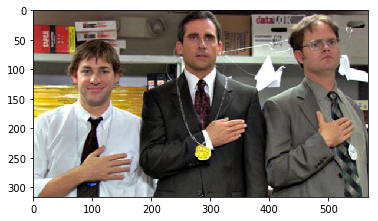

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("Office.png")
plt.imshow(img)

# We have a 317x568 RGB image as a numpy array.
print(type(img))
print(img.shape)

In [0]:
# 2. Crop image so that our sample contains only pixels of skin color.
import numpy as np
img_copy = np.copy(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


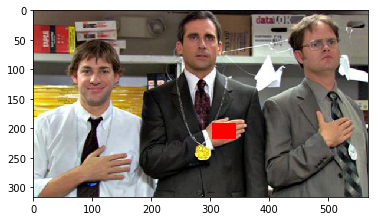

In [62]:
# Used this to zoom into Michael's hand.
bb_r = 192
bb_c = 304
bb_h = 27
bb_w = 40
img_copy[bb_r:bb_r+bb_h,bb_c:bb_c+bb_w] = [255,0,0]
plt.imshow(img_copy)

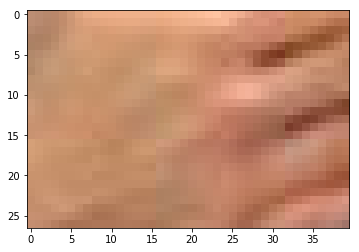

In [91]:
sample = np.zeros((bb_h,bb_w,3)) # Create RGB array for cropped image.
for r in range(sample.shape[0]):
  for c in range(sample.shape[1]):
    sample[r][c] = img[bb_r+r][bb_c+c]
    
plt.imshow(sample)

In [0]:
# 3. Convert result into our color space, YCbCr.
def RGB_to_YCbCr(rgb):
  if len(rgb) != 3:
    print("Error: Pixel doesn't have 3 elements.")
    return
  output = np.zeros(3)
  output[0] =  0.2568*rgb[0] + 0.5041*rgb[1] + 0.0979*rgb[2] + 0.0625
  output[1] = -0.1482*rgb[0] - 0.2910*rgb[1] + 0.4392*rgb[2] + 0.5
  output[2] =  0.4392*rgb[0] - 0.3678*rgb[1] + 0.0714*rgb[2] + 0.5
  
  return output

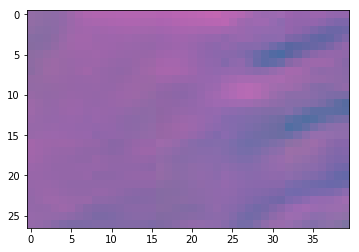

In [99]:
yCbCr = np.zeros((bb_h,bb_w,3))
for r in range(yCbCr.shape[0]):
  for c in range(yCbCr.shape[1]):
    yCbCr[r][c] = RGB_to_YCbCr(img[bb_r+r][bb_c+c])
    
plt.imshow(yCbCr)
yCbCr = yCbCr * 256 # Matplotlib wanted integers for the 0-255 range.

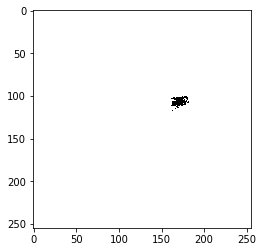

In [103]:
# 4. Plot all pixels in skin sample in CbCr plane, a 255x255 result.
cbcrPlane = np.zeros((255,255))

for r in range(yCbCr.shape[0]):
  for c in range(yCbCr.shape[1]):
    pixel = yCbCr[r,c]
    cb = int(round(pixel[1])) # Makes these integers.
    cr = int(round(pixel[2]))
    cbcrPlane[cb,cr] = 1
    
plt.imshow(cbcrPlane, cmap='Greys')

In [0]:
# 5. Dilate and erode this result to smooth out the free-form skin model.
def splitKernel(kernel):
  """Splits given kernel into individual offsets from its center.
  Also gives maximum offsets in order left right up down."""
    
  if not isinstance(kernel, np.ndarray):
    print("Error: Invalid kernel. Need numpy array")
    return None
  
  # Require 2D array.
  if len(kernel.shape) != 2:
    print("Error: Invalid kernel. Need 2D array")
    return None
  
  height = kernel.shape[0]
  width = kernel.shape[1]
  
  # Require odd dimensions on kernel. Input pixel at center.
  if (height % 2 != 1) or (width % 2 != 1):
    print("Error: Invalid kernel. Need odd dimensions")
    return None
  
  center_r = int(height) // 2
  center_c = int(width) // 2
  outputs = []
  
  # Loop over all pixels
  for r in range(height):
    for c in range(width):
      if kernel[r][c] == 1:
        outputs.append((r - center_r, c - center_c))
        
  return outputs

def maxOffsets(offsets):
  # Do this to avoid if statements on all input pixels.
  left = 0
  right = 0
  up = 0
  down = 0
  
  # Find max offset in each direction.
  for o in offsets:
    left = max(left, -o[1])
    right = max(right, o[1])
    up = max(up, -o[0])
    down = max(down, o[0])
    
  return left,right,up,down

def dilate(image, kernel):
  """Dilate the given image using the given kernel.
  Note: Only uses binary images/kernel."""
  
  # Split the kernel into individual offset coordinates.
  kernel_parts = splitKernel(kernel)
  
  # Fetch the maximum offsets from any input pixel in our kernel.
  left,right,up,down = maxOffsets(kernel_parts)
  
  output = np.zeros(image.shape)
  
  # Main part of image checking, no if statements needed:
  for r in range(0 + up, image.shape[0] - down):
    for c in range(0 + left, image.shape[1] - right):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if image[curr_r][curr_c] == 1:
          output[r][c] = 1
          
  # Now cover four sides and corners:
  
  # Left side:
  for r in range(0 + up, image.shape[0] - down):
    for c in range(0, left):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_c >= 0:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
            
  # Right side:
  for r in range(0 + up, image.shape[0] - down):
    for c in range(image.shape[1] - right, image.shape[1]):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_c < image.shape[1]:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
  
  # Top side:
  for r in range(0, up):
    for c in range(0 + left, image.shape[1] - right):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r >= 0:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
            
  # Bottom side:
  for r in range(image.shape[0] - down, image.shape[0]):
    for c in range(0 + left, image.shape[1] - right):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r < image.shape[0]:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
  
  # Left top corner:
  for r in range(0, up):
    for c in range(0, left):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r >= 0 and curr_c >= 0:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
          
  # Right top corner:
  for r in range(0, up):
    for c in range(image.shape[1] - right, image.shape[1]):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r >= 0 and curr_c < image.shape[1]:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
            
  # Left bottom corner:
  for r in range(image.shape[0] - down, image.shape[0]):
    for c in range(0, left):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r < image.shape[0] and curr_c >= 0:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
            
  # Right bottom corner:
  for r in range(image.shape[0] - down, image.shape[0]):
    for c in range(image.shape[1] - right, image.shape[1]):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r < image.shape[0] and curr_c < image.shape[1]:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
            
  return output

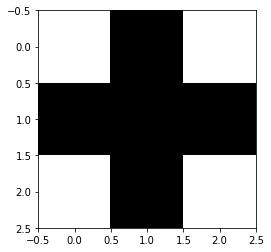

In [150]:
kernel_cross = np.array([[0,1,0],[1,1,1],[0,1,0]])
kernel_3x3 = np.array([[1,1,1],[1,1,1],[1,1,1]])
plt.imshow(kernel_cross, cmap='Greys')

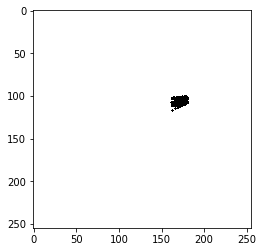

In [151]:
cross = dilate(cbcrPlane, kernel_cross)
plt.imshow(cross,cmap='Greys')

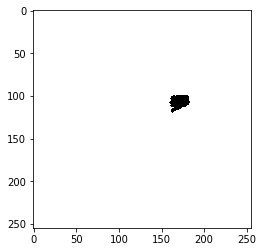

In [152]:
cross = dilate(cross, kernel_cross)
plt.imshow(cross, cmap='Greys')

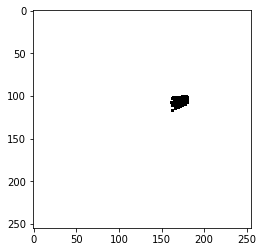

In [153]:
box = dilate(cbcrPlane, kernel_3x3)
plt.imshow(box,cmap='Greys')

Two dilations with the cross kernel seem to have about the same impact as one with the box kernel, except the box loses definition and seems to round out edges more than I'd like. Maybe three dilations with the cross, then an erosion? We'll see. *Last revised 7/21/2019*